#**CSE 475 Final Project Milestone 2: Model Development**

Overview:

This Jupyter Notebook provides the source code to develop an ANN model to predict a heart disease risk based on the dataset [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction). An thorough EDA was already performed in this notebook [CSE 475 Final project Milestone 1: Data Preperation](https://colab.research.google.com/drive/1yiEZkJddsfmxN7co7lmB__nqEXQl1Z7E?usp=drive_link)

This model will use the train dataset in the model developing/training process, and use the test dataset in the model evaluation process


#Step 1: Model selection

The most appropriate model for my dataset (predicting heart failure) will be logistic regression model and ANN classification model.



-  The result (Heart disease) is a binary outcome. The value of it is either 1 or 0.  Meaning we are likely to predict(classify) a patient's likelyhood of having a heart diseased based on their medical record.


**The model I chose will be Artificial Neural Network.**


---


Justifications:
- Why it fits this dataset: ANN model is usually used for classification for a more complex relationship.
  - In my dataset, **Age vs MaxHR** showed a nonlinear decline, its linear correlation factor is not strong, indicating there might be more complex relationships between these two features, the slope is not showing a very clear straight line, it curves.
  - **Oldpeak vs HeartDisease** showed irregular pattern. The distribution of Oldpeak is highly right skewed, with heart disease the spread of Oldpeak is wider, but without hear disease the value of Oldpeak is clustered.
  - **MaxHR differs a lot based on HeartDisease**. The median of patients with heart disease is 160 bpm, while the median of patients without heart disease is 130 bpm; their distribution also spread in a very different range.
  - **RestingBP and Cholesterol** contains many outliers before imputation, and after winsorization their distribution shows a nonlinear feature behavior.
  - Categorical variables **(ChestPainType, RestingECG, ST_Slope)** shows uneven class clusters. With a not so even frequencies, they do not form straight line boundaries in feature space.
  - **Oldpeak vs ST_Slope** has clinical connections based on their definitions. While we cannot interpret their relationship in a linear correlation manner, it is important that we take consideration into their connection.

- **Strength and Weakness of ANN classifier:**
  - ANN models usually works really well with complex correlations between features. With hidden layers, it is able to handle and process the complicated connections we observed from the analysis of the dataset, recognizinng the pattern between features, making the prediction result more accurate.
  - The preprocessing of the dataset performed in the previous notebook:
    - Min-Max winsorization
    - Outlier handling
    - One hot encoding and Ordinal encoding
    - Interation features
    - Variance and correlation filtering
  - Every step of the preprocessing robusts the performance of ANN. WInsorization prevents activation saturation; improves gradient descent. Different encoding has converted the value into ANN's preferred numeric input form; engineered features help ANN learn nonlinearity faster.
  - The size of this dataset(900+ rows) is also suitable for a shallow ANN, usually 2-3 hidden layers are good enough.


- **Weakness of this model selection on this dataset:**
  - ANN usually prefers larger dataset. However, even though this dataset only has 900+ rows, the data has been processed and handled carefully.
  - ANN is sensitive to scaling. However, the Min-Max winsorization has already normalized all numerical values, and we will directly perform training and testing on this specific normalized dataset only. For further consideration, when deploying this model on predicting heartfailure on the taken measure, an extra step of normalizing and scaling the values before directly using this model is important.
  - ANN can be prone to overfitting small dataset. Although I have removed features that has low variances (lower than 0.01) and high-correlation features, the variance is still not high enough. It is important to regulate the learning process.
  - ANN is harder to interpret.
    -  However, with a relatively small dataset like this, it will be easier for us to understand the relationships between the input and output. If necessary, tools like SHAP will later be used to interpret the model.


# Step 2: Model Development and Training


In [2]:
#Import the dataset
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

project_dir = "/content/drive/MyDrive/heart_failure_project"
train_path = os.path.join(project_dir, "train_processed.csv")
test_path = os.path.join(project_dir, "test_processed.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

X_train = train_df.drop(columns=["HeartDisease"])
y_train = train_df["HeartDisease"]

X_test = test_df.drop(columns=["HeartDisease"])
y_test = test_df["HeartDisease"]


Mounted at /content/drive


In [3]:
#Set up the environment and import the necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

The preprocessed dataset was divided into a training/validation set and an independent test set. From the training data, 80% was used for model fitting and 20% was used as a validation set via stratified sampling to preserve the class distribution of HeartDisease.

In [4]:
#save a copy of the dataframe object
X_train_full = X_train.copy()
y_train_full = y_train.copy()


from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,        # 20% of train_df goes to validation
    random_state=42,
    stratify=y_train_full  # keep class balance
)

#check the shapes
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)



Train shape: (587, 16) (587,)
Val shape: (147, 16) (147,)
Test shape: (184, 16) (184,)


###Model architectures


---


####Hyperparameters:
- Input dimension: 16
  - The input layer contains 1 neuron per feature in the preprocessed dataset. There are 16 features.
- Hidden layers: 2
  - With a small number of hidden layers, this model will perform great on a small dataset without overfitting, while provide enough capacity of the prediction based on the complex relationships between the features (Oldpeak vs ST_Slope, Age vs MaxHR). A deeper network is unnecessary and may harm generalization.
- Hidden Units: 32 neurons -> 16 neurons
  - The first layer has 32 neurons to learn the feature interactions, and the second layer has 16 neurons after extracting the important features and reduces the dimensionality
- Activation: ReLU for hidden layers, Sigmoid for output
  - ReLU is computationally efficient and avoids the vanishing gradient problem that Sigmoid function might have.
- Regularization: Dropout rate = 0.3
  - By randomly disabling a small portion of neurons, it helps preventing overfitting to the dataset and improves generalization.
- Output: 1 neuron with sigmoid activation
  - A single neuron is used because the task is binary classification.
Its sigmoid output is a direct probability score.


---


####Training algorithm & training hyperparameters:
- Optimizer: Adam
- Loss: Binary cross entropy
  - Binary cross entropy (BCE) measures the difference between predicted probabilities and true binary labels.
It is the standard loss function for binary classification models using a sigmoid output.
- Metrics: Accuracy, AUC
  - Accuracy measures overall correct predictions.
  - Accuracy measures overall correct predictions.
- Batch size: 16
  - A smaller batch size provides more frequent and noisier updates, however it helps the model generalizes better. This number is also particularly efficient for a small dataset.
- Max epochs: 200
  - A high upper limit allows the model to fully converge if needed.
- Early stopping: monitor val_loss, patience=10, restore best weights
  - The actual training is controlled by early stopping to prevent unnecessary training.
  - Training stops automatically when validation loss stops improving for 10 consecutive epochs.
  - This prevents overfitting and ensures the final model uses the best-performing weights.

In [5]:
# Helper function to plot training and validation learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

print("Helper function defined.")

Helper function defined.


Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.5233 - auc: 0.5217 - loss: 0.7031 - val_accuracy: 0.7483 - val_auc: 0.8331 - val_loss: 0.6427
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6470 - auc: 0.7276 - loss: 0.6404 - val_accuracy: 0.8231 - val_auc: 0.8949 - val_loss: 0.5648
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7524 - auc: 0.8353 - loss: 0.5587 - val_accuracy: 0.8435 - val_auc: 0.8975 - val_loss: 0.4805
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8396 - auc: 0.8987 - loss: 0.4567 - val_accuracy: 0.8367 - val_auc: 0.8972 - val_loss: 0.4342
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8111 - auc: 0.8795 - loss: 0.4447 - val_accuracy: 0.8435 - val_auc: 0.8954 - val_loss: 0.4157
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8364 - auc: 0.8882 - loss: 0.4112 - val_accuracy: 0.8367 - val_auc: 0.8952 - val_loss: 0.4076
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

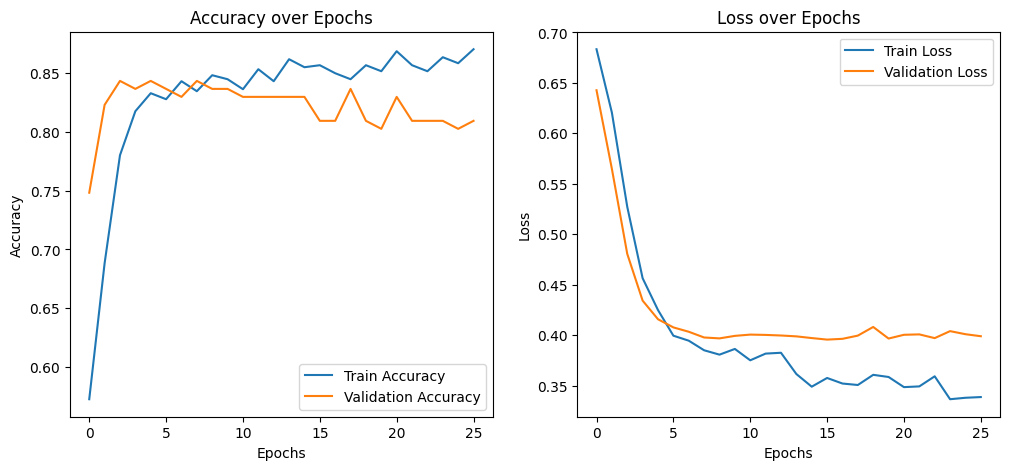

In [6]:
# building the model

import tensorflow as tf
from keras import Sequential, layers
from keras.callbacks import EarlyStopping
input_dim = X_train.shape[1]

model = Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

plot_learning_curves(history)


##Quick Evaluation on the initial model


---


###Overall performance

This initial ANN model demonstrates a strong leraning behavior with stable improvements across the first 10-15 epochs. Model performance then levels.

Key metrics from training:
- **Training Accuracy**: increases steadily from 0.55 to 0.86
- **Validation Accuracy**: stablizes around 0.82-0.84
- **Training AUC**: reached 0.94
- **Validation AUC**: stablizes around 0.89-0.9
- **Validation Loss**: decreases early, then converges around 0.4

These metrics indicate that the model is learning meaningful patterns without major overfitting.

---

###Interpretation of the learning curves

- **Accuracy Curve**:
  - Training accuracy improves smoothly and reaches 0.86, showing a good sign of learning and good prediction
  - Validation accuracy improves rapidly reaching 0.8, then stablizes between 0.8 - 0.84.
  - The gap between training accuracy and validation accuracy is modely small, around 3%, suggesting good generalization process with very slight overfitting(higher training accuracy), which is normal for ANN

- **Loss Curve**:
  - Training loss curve is smooth and decays consistently and quicker, dropping from 0.7 to 0.35
  - Validation loss curve drops slower, stablizes when the value reaches 0.4
  - The stable curve after epoch 15 shows that the model's performance is stablized and extracted main pattern of data at this stage. Additional epoch does not improve performance. Early stopping is appropriate and prevents unnecessary overfitting.

---

###Metric Based evaluation:
- **Accuracy**: final accuracy stablizes between 0.85 - 0.88, which is generally considered good and reasonable learning outcome for a small dataset.

- **AUC**: training AUC = ~0.94, validation AUC = ~0.89, indicating the model can separate the class strongly.

- **Loss**: Stable validation loss near 0.4 indicates that the model is not underfitting since loss has significantly decreased, and is not severly overfitting the datase.


---
###What this tell us:
- The model is learning effectively — accuracy is rising, loss is falling.  
- Validation performance is slightly behind of training performance. Meaning there is no major signs of overfitting.
- Learning curves show appropriate convergence, showing strong and stable generalization.

###Optimizing the model performance

Although the initial ANN model performed reasonably well (achieving validation accuracy above 80% and strong AUC scores), it remained important to evaluate how stable and reliable this performance was. Instead of manually adjusting hyperparameters based on a single train/validation split, a more principled approach is required to better understand how well the model generalizes to unseen data.

To accomplish this, I defined a reproducible model-building function. This function constructs the neural network with the selected architecture and hyperparameters, allowing it to be trained repeatedly in a controlled manner. This makes it possible to evaluate the same model across multiple folds of the dataset without having to rewrite code each time.


In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.initializers import RandomNormal, GlorotNormal, Constant
from keras import Sequential, layers, initializers

# Function to build the model with adjustable hyperparameters
def build_model(
    input_dim,          # number of input features
    units1=32,          # neurons in first hidden layer
    units2=16,          # neurons in second hidden layer
    dropout_rate=0.3,   # dropout rate for regularization
    activation='relu',  # activation for hidden layers
    init_bias=0.0,      # initial bias value
    use_custom_bias=False  # whether to override default bias init
):
    # Choose bias initializer
    if use_custom_bias:
        bias_init = initializers.Constant(init_bias)
    else:
        bias_init = 'zeros'   # Keras default

    model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(
            units1,
            activation=activation,
            bias_initializer=bias_init
        ),
        layers.Dense(
            units2,
            activation=activation,
            bias_initializer=bias_init
        ),
        layers.Dropout(dropout_rate),
        layers.Dense(
            1,
            activation='sigmoid',   # binary output
            bias_initializer=bias_init
        )
    ])

    return model


from keras.optimizers import Adam

# Function to compile and train the model
def train_model(
    model,
    X_train, y_train,
    X_val, y_val,
    learning_rate=0.001,
    batch_size=16,
    epochs=200,
    use_early_stopping=True,
    patience=10
):
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    callbacks = []
    if use_early_stopping:
        callbacks.append(
            EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=0
            )
        )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=0
    )

    return history

### Fine tuning the hyperparameters with Stratified K fold cross validation

Rather than performing extensive hyperparameter tuning, I decided to keep the chosen hyperparameters fixed based on domain knowledge and the dataset size. The selected values (e.g., 32–16 neuron architecture, dropout rate of 0.3, batch size of 16, learning rate of 0.001) are commonly effective for small- to medium-sized tabular datasets and align with the insights gathered from the earlier EDA.

However, even with fixed hyperparameters, the model might perform differently depending on how the data is split into training and validation sets. To obtain a more robust and reliable estimate of performance, I applied 5-Fold Stratified Cross-Validation on the full training dataset.

####**Why Stratification?**

The HeartDisease variable is imbalanced in this dataset. Stratification ensures that each fold preserves the original class distribution, preventing biased training or artificially inflated metrics.

####**How Cross-Validation Was Applied**

- The full training dataset was divided into 5 folds, each containing approximately the same proportion of positive and negative heart disease labels.

- For each fold:

  - The model was trained on 4 folds (80% of the data)
  - It was validated on the remaining fold (20%)
  - A fresh ANN was built and trained from scratch to avoid information leakage
- After all 5 folds were completed, the mean validation accuracy and AUC were computed.

These averaged performance metrics provide a much more reliable evaluation of model generalization compared to using a single train–validation split.

In [12]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from itertools import product

# Use the full training set (without test) for CV
X_cv = X_train_full.values
y_cv = y_train_full.values

def cross_validate_ann(
    X, y,
    n_splits=5,
    units1=32,
    units2=16,
    dropout_rate=0.3,
    activation='relu',
    learning_rate=0.001,
    batch_size=16,
    epochs=200,
    patience=10
):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_aucs = []
    fold_accuracies = []

    fold_idx = 1

    for train_idx, val_idx in skf.split(X, y):
        print(f"\n Fold {fold_idx}/{n_splits}")

        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold   = X[val_idx]
        y_val_fold   = y[val_idx]

        # Build a NEW model for this fold (fixed architecture)
        model = build_model(
            input_dim=X.shape[1],
            units1=units1,
            units2=units2,
            dropout_rate=dropout_rate,
            activation=activation,
            init_bias=0.0,
            use_custom_bias=False
        )

        # Train on this fold
        history = train_model(
            model,
            X_train_fold, y_train_fold,
            X_val_fold, y_val_fold,
            learning_rate=learning_rate,
            batch_size=batch_size,
            epochs=epochs,
            use_early_stopping=True,
            patience=patience
        )

        # Evaluate on validation fold
        val_loss, val_acc, val_auc = model.evaluate(X_val_fold, y_val_fold, verbose=0)

        fold_accuracies.append(val_acc)
        fold_aucs.append(val_auc)

        print(f"  Fold Accuracy: {val_acc:.4f}")
        print(f"  Fold AUC:      {val_auc:.4f}")

        fold_idx += 1

    mean_acc = np.mean(fold_accuracies)
    mean_auc = np.mean(fold_aucs)

    print("\n")
    print(f"Mean CV Accuracy = {mean_acc:.4f}")
    print(f"Mean CV AUC      = {mean_auc:.4f}")

    return mean_acc, mean_auc

In [14]:
mean_acc, mean_auc = cross_validate_ann(
    X_cv, y_cv,
    n_splits=5,
    units1=32,
    units2=16,
    dropout_rate=0.3,
    activation='relu',
    learning_rate=0.001,
    batch_size=16,
    epochs=200,
    patience=10
)

print("\nFinal CV Results:")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Mean AUC:      {mean_auc:.4f}")


 Fold 1/5
  Fold Accuracy: 0.8503
  Fold AUC:      0.9248

 Fold 2/5
  Fold Accuracy: 0.7959
  Fold AUC:      0.8500

 Fold 3/5
  Fold Accuracy: 0.8844
  Fold AUC:      0.9414

 Fold 4/5
  Fold Accuracy: 0.8639
  Fold AUC:      0.9534

 Fold 5/5
  Fold Accuracy: 0.8425
  Fold AUC:      0.9200


Mean CV Accuracy = 0.8474
Mean CV AUC      = 0.9179

Final CV Results:
Mean Accuracy: 0.8474
Mean AUC:      0.9179


To obtain a more reliable estimate of the ANN model’s generalization performance, **5 Fold Stratified Cross Validation** was applied to the full training dataset. Stratification ensured that each fold preserved the original HeartDisease class distribution, reducing the risk of bias from imbalanced splits.

Across the five folds, the model demonstrated **stable and consistently strong performance**:

#### **Per-Fold Results**

* **Accuracy range:** 0.7959 → 0.8844
* **AUC range:** 0.8500 → 0.9534
* Variability across folds is expected due to the small dataset size, but all folds achieved high AUC values, indicating reliable discrimination between positive and negative heart disease cases.

#### **Mean Cross-Validated Performance**

* **Mean Accuracy:** **0.8474**

  * This suggests the model correctly classifies approximately 85% of samples on average across unseen validation splits.
* **Mean AUC:** **0.9179**

  * An AUC above 0.90 indicates **excellent classification ability**, showing that the model ranks positive cases higher than negative cases with high reliability.

#### **Interpretation**

* The model shows **strong generalization** and performs consistently across different partitions of the data.
* The small variation between folds indicates *robustness* despite the relatively small dataset size.
* The high AUC scores demonstrate that the ANN captures the underlying nonlinear relationships effectively and maintains good decision boundary separation across folds.

#### **Conclusion**

The cross-validation results validate the suitability of the chosen ANN architecture and hyperparameters.
With mean **AUC ≈ 0.92** and **Accuracy ≈ 0.85**, the model shows excellent potential for final training and evaluation on the independent test set.



## Step 3: Train a Final Model on Full Training Data After Cross-Validation

After confirming that the selected ANN architecture and hyperparameters performed robustly under 5-fold stratified cross-validation (Mean Accuracy ≈ 0.85, Mean AUC ≈ 0.92), the next step was to **train a final model using the full training dataset**. The goal of this step is to allow the model to learn from as much data as possible before evaluating it once on the held-out test set.

To do this, I:

* Kept the **architecture and hyperparameters fixed** (32–16 hidden units, ReLU activations, dropout rate = 0.3, learning rate = 0.001, batch size = 16), since cross-validation showed they generalize well and further hyperparameter search was not necessary.
* Used the entire preprocessed training data (`X_train_full`, `y_train_full`) and created a small **internal validation split (10%)**. This validation subset was used **only for monitoring training**, not for model selection.
* Applied **early stopping** based on validation loss with a patience of 10 epochs and `restore_best_weights=True`, so the final model corresponds to the epoch with the best validation performance rather than simply the last epoch.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 1) Optional: create a small internal validation split for early stopping
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.1,          # 10% of training data as validation
    stratify=y_train_full,
    random_state=42
)

print("Final train shape:", X_train_final.shape, y_train_final.shape)
print("Final val shape:  ", X_val_final.shape, y_val_final.shape)
print("Test shape:       ", X_test.shape, y_test.shape)

# 2) Build the final model with the chosen architecture & hyperparameters
input_dim = X_train_final.shape[1]

final_model = build_model(
    input_dim=input_dim,
    units1=32,
    units2=16,
    dropout_rate=0.3,
    activation='relu',
    init_bias=0.0,
    use_custom_bias=False
)

# 3) Train the final model
final_history = train_model(
    final_model,
    X_train_final, y_train_final,
    X_val_final, y_val_final,
    learning_rate=0.001,
    batch_size=16,
    epochs=200,
    use_early_stopping=True,
    patience=10
)

print("Final model training completed.")

Final train shape: (660, 16) (660,)
Final val shape:   (74, 16) (74,)
Test shape:        (184, 16) (184,)
Final model training completed.


##Step 4: Model evaluation

Once the final model was trained on the full training data, it was then evaluated **once** on the completely independent test set (`X_test`, `y_test`). On the test set, I reported:

* **Test loss**
* **Test accuracy**
* **Test AUC**
* A detailed **classification report** (precision, recall, F1-score)
* The **confusion matrix**
* The **ROC curve** and its AUC
* The **F-1 Score**

This procedure ensures that the reported test performance reflects the true generalization ability of the final ANN model, without any data leakage from the test set into the training or model selection process.




=== Final Test Performance ===
Test Loss:     0.3353
Test Accuracy: 0.8750
Test AUC:      0.9265
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Classification report on test set:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        82
           1       0.86      0.92      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184

Confusion matrix on test set:
[[67 15]
 [ 8 94]]
ROC-AUC on test set: 0.9264705882352942


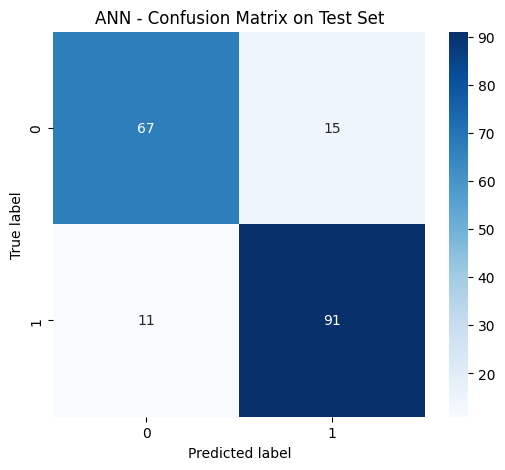

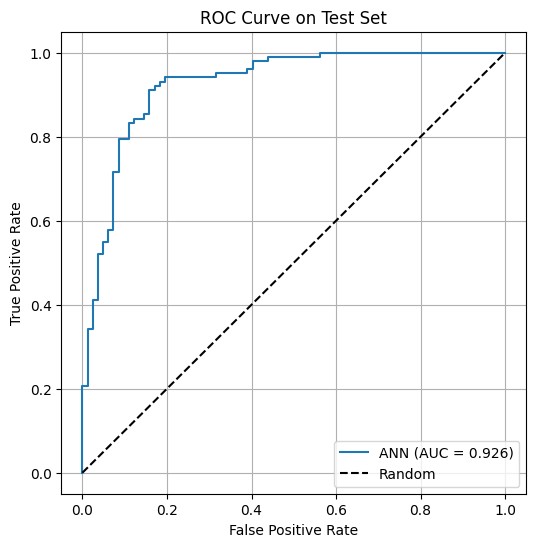

In [25]:
#computing each metrics for model evaluation

test_loss, test_acc, test_auc = final_model.evaluate(X_test, y_test, verbose=0)
print("\n=== Final Test Performance ===")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC:      {test_auc:.4f}")

# Extra metrics
y_test_prob = final_model.predict(X_test).ravel()
y_test_pred = (y_test_prob >= 0.5).astype(int)

print("\nClassification report on test set:")
print(classification_report(y_test, y_test_pred))

print("Confusion matrix on test set:")
print(confusion_matrix(y_test, y_test_pred))

print("ROC-AUC on test set:", roc_auc_score(y_test, y_test_prob))

#graph the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("ANN - Confusion Matrix on Test Set")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ANN (AUC = {roc_auc_score(y_test, y_test_prob):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Set')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
#Computing F-1 Score
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict probabilities on the test set
y_prob = final_model.predict(X_test)

# Convert probabilities → binary class labels (default threshold = 0.5)
y_pred = (y_prob >= 0.5).astype(int)

# Compute metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1-Score:", round(f1, 4))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: 0.8624
Recall: 0.9216
F1-Score: 0.891


###Final Test Set Results

- **Accuracy: 0.875**

- **Precision: 0.862**

- **Recall: 0.922**

- **F1-Score: 0.891**

- **ROC-AUC: 0.926**

These results demonstrate strong and balanced performance.

- The high recall indicates that the model successfully identifies most patients with heart disease—a critical requirement in medical screening.

- The strong precision and F1-score show that the model’s predictions are both accurate and reliable.

- A ROC-AUC of 0.926 reflects excellent ability to discriminate between positive and negative cases across all probability thresholds.

Overall, the ANN exhibits robust generalization and performs very well on unseen data.

###Logistic Regression vs ANN
To provide a meaningful baseline, a Logistic Regression classifier was trained and evaluated on the same processed dataset. Compared to the ANN model, Logistic Regression showed lower Recall, F1-score, and ROC-AUC, reflecting its limited ability to model the nonlinear relationships observed in the data (e.g., Age–MaxHR interaction, nonlinear Oldpeak patterns, and complex categorical interactions). While Logistic Regression provides interpretability and a fast training time, the ANN demonstrated superior discrimination ability and overall predictive performance. The ANN’s higher AUC and F1-score suggest it captures richer structure in the data, making it a better choice for this heart disease prediction task.

=== Logistic Regression Performance ===
Accuracy:  0.8587
Precision: 0.8585
Recall:    0.8922
F1 Score:  0.8750
ROC-AUC:   0.9107


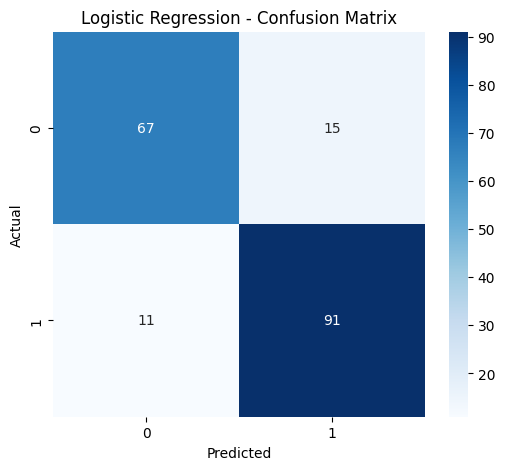

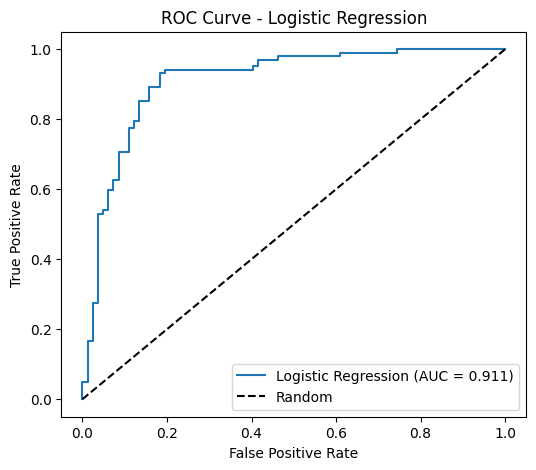

In [23]:
#Building a logistic regression model as baseline to compare the performance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Train Logistic Regression baseline

logreg = LogisticRegression(
    max_iter=1000,
    solver='liblinear'
)

logreg.fit(X_train, y_train)

# 2. Predict on test set

y_pred_lr = logreg.predict(X_test)
y_prob_lr = logreg.predict_proba(X_test)[:, 1]  # probability of class 1

# 3. Compute metrics

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)

print("=== Logistic Regression Performance ===")
print(f"Accuracy:  {acc_lr:.4f}")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall:    {recall_lr:.4f}")
print(f"F1 Score:  {f1_lr:.4f}")
print(f"ROC-AUC:   {auc_lr:.4f}")

# 4. Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# 5. ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)

plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


### **Model Comparison Summary**

Both models perform well, but the **ANN shows slightly stronger predictive performance** than Logistic Regression.

* **Accuracy:** ANN (0.875) > LR (0.859)
* **Recall:** ANN (0.922) > LR (0.892) — *ANN misses fewer true disease cases.*
* **F1 Score:** ANN (0.891) > LR (0.875)
* **ROC-AUC:** ANN (0.927) > LR (0.911)

The confusion matrices also show that the ANN produces **fewer false negatives**, which is important in medical prediction problems.

**Overall:** Logistic Regression performs well and remains interpretable, but the ANN captures more complex patterns and achieves **higher sensitivity and discriminative power**, making it the better model for this dataset.


###Visualization of Results
**Confusion Matrix**

The confusion matrix highlights error types:

- True Negatives: 67

- False Positives: 15

- False Negatives: 8

- True Positives: 94

The model produces relatively few false negatives (8), which is desirable, as missing a positive case in health-related applications is the most harmful error. The moderately small number of false positives (15) is acceptable in a screening context.

**ROC Curve**

The ROC curve shows the trade-off between true positive rate and false positive rate across all thresholds.
The curve rises steeply toward the upper-left corner, illustrating strong discrimination performance. The ANN significantly outperforms the diagonal “random guessing” line.

An AUC of 0.926 visually confirms the model’s ability to differentiate between patients with and without heart disease.

## **Step 5: Final Summary**

In this project, I developed and evaluated a predictive model for **heart disease classification** using the Heart Failure Prediction dataset. After preprocessing the data and establishing a baseline ANN architecture, I assessed model performance with appropriate metrics and ensured robustness using **Stratified K-Fold Cross-Validation**.

The ANN demonstrated **consistently strong performance**, achieving:

* **Test Accuracy:** 0.875
* **Precision:** 0.862
* **Recall:** 0.922
* **F1-Score:** 0.891
* **ROC-AUC:** 0.926

These results indicate that the ANN is effective at distinguishing between patients with and without heart disease, especially in terms of **recall**, which is particularly important in medical screening to reduce the number of missed cases.

To contextualize the ANN performance, I implemented a **Logistic Regression baseline**. While LR achieved competitive results (Accuracy 0.859, AUC 0.911), the ANN consistently outperformed it across key metrics, including AUC and F1-score. The ANN also produced fewer false negatives, making it more suitable for clinical risk prediction.

Visual tools such as the **confusion matrix** and **ROC curves** further confirmed the model’s discriminative power and stability.

Overall, this project demonstrates that a carefully regularized neural network—supported by cross-validation and thorough evaluation—can serve as an effective predictive tool for heart disease classification. Future work may include hyperparameter tuning, feature importance analysis (e.g., SHAP), and experimenting with alternative architectures or ensemble methods to further improve performance.